In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, roc_curve, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM

import joblib

In [40]:
df = pd.read_csv("billets.csv", sep=";")

df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


Exploration

In [41]:
mask_true = df['is_genuine'] == True
mask_false = df['is_genuine'] == False

cols = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

In [42]:
df['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

In [43]:
df[mask_true][cols].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,971.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.116097,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.319124,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.905000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.110000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [44]:
df[mask_false][cols].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,492.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.215935,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.553531,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.592500,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


In [45]:
# Que faire des lignes avec des valeurs manquantes ? 
# Option 1 : supprimer ces lignes pour éviter de biaiser le modèle

#df_clean = df.dropna(subset=['margin_low'])
#print(df_clean['margin_low'].isna().sum())

In [46]:
# Option 2 : compléter valeurs manquantes de margin_low avec régression linéaire

cols_predict = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

train = df[df['margin_low'].notna()]
X = train[cols_predict]
y = train['margin_low']

lr = LinearRegression()

lr.fit(X, y)

y_pred = lr.predict(X)

r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R² = {r2:.3f}")
print(f"MAE = {mae:.3f}")

# R2 : Le modèle capture presque la moitié de la variance. Il serait parfait à 1
# MAE = l'erreur moyenne absolue entre les valeurs prédites et réelles

R² = 0.477
MAE = 0.372


In [ ]:
# validation de la liste des colonnes prédictives
# Un p-value bas pour chaque variable (P>|t|) prouve que chaque valeur est nécessaire.

X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:              margin_low   R-squared:                       0.477
Model:                             OLS   Adj. R-squared:                  0.476
Method:                  Least Squares   F-statistic:                     266.1
Date:              ven., 06 févr. 2026   Prob (F-statistic):          2.60e-202
Time:                         12:37:09   Log-Likelihood:                -1001.3
No. Observations:                 1463   AIC:                             2015.
Df Residuals:                     1457   BIC:                             2046.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656    

In [48]:
mask_reel = df['margin_low'].notna()
mask_impute = df['margin_low'].isna()

In [49]:
# Compléter les valeurs manquantes

df.loc[mask_impute, 'margin_low'] = lr.predict(df.loc[df['margin_low'].isna(), cols_predict])

C:\Users\Morgi\AppData\Local\Temp\ipykernel_13388\424347371.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Origine', y='margin_low', data=df_visu, palette={'Réel': 'skyblue', 'Imputé': 'salmon'})


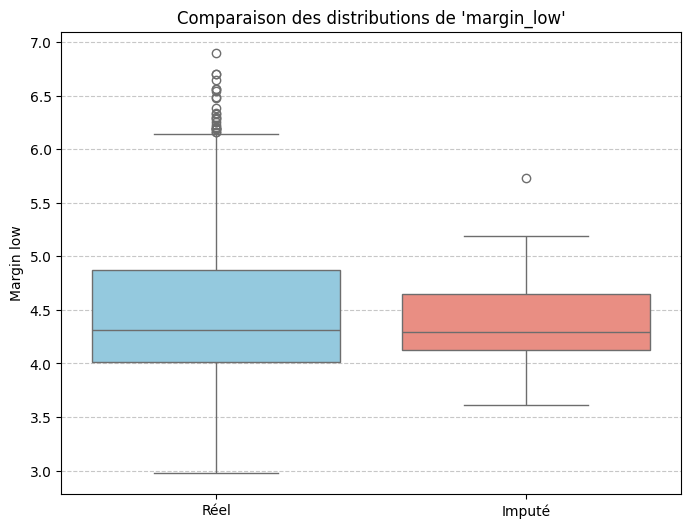

In [50]:
df_visu = df.copy()
df_visu['Origine'] = 'Réel'
df_visu.loc[mask_impute, 'Origine'] = 'Imputé'

plt.figure(figsize=(8, 6))

sns.boxplot(x='Origine', y='margin_low', data=df_visu, palette={'Réel': 'skyblue', 'Imputé': 'salmon'})

plt.title("Comparaison des distributions de 'margin_low'")
plt.ylabel("Margin low")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

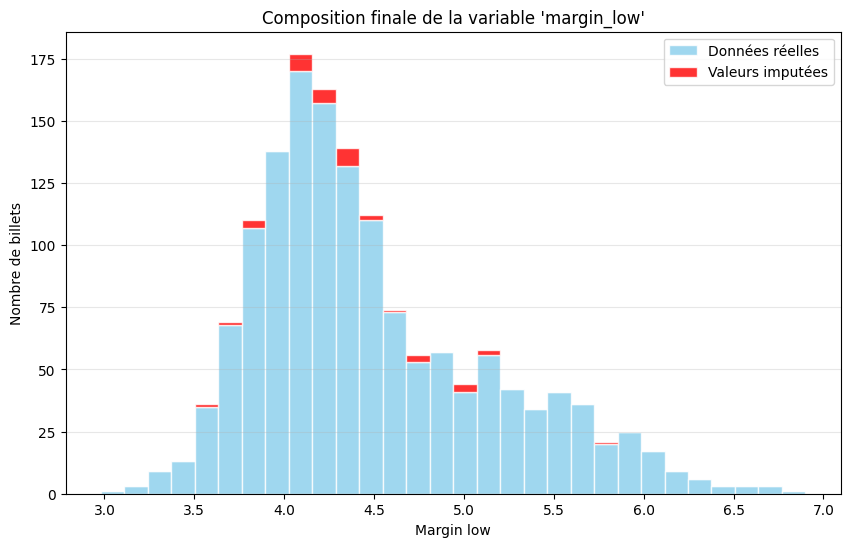

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# On crée deux listes de données pour l'histogramme
data_reel = df.loc[mask_reel, 'margin_low']
data_impute = df.loc[mask_impute, 'margin_low']

# On affiche l'histogramme empilé
plt.hist([data_reel, data_impute], bins=30, stacked=True, 
         color=['skyblue', 'red'], label=['Données réelles', 'Valeurs imputées'],
         edgecolor='white', alpha=0.8)

plt.title("Composition finale de la variable 'margin_low'")
plt.xlabel("Margin low")
plt.ylabel("Nombre de billets")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [52]:
# Test Manova permet de savoir si les classes sont séparables dans l'espace multivarié

manova = MANOVA.from_formula(' + '.join(cols) + ' ~ is_genuine', data=df)
print(manova.mv_test())

# Wilks’ Lambda = 0 signifie que le modèle explique parfaitement la variance, 1 signifie que le modèle n'explique rien.
# Plus Pillai’s Trace est proche de 1, mieux c'est 
# Hotelling-Lawley & Roy : si fortes, signifient qu'au moins une combinaison de variables séparent bien les billets

                        Multivariate linear model
                                                                         
-------------------------------------------------------------------------
       Intercept           Value    Num DF   Den DF     F Value    Pr > F
-------------------------------------------------------------------------
          Wilks' lambda      0.0000 6.0000 1493.0000 49617069.1668 0.0000
         Pillai's trace      1.0000 6.0000 1493.0000 49617069.1668 0.0000
 Hotelling-Lawley trace 199398.8044 6.0000 1493.0000 49617069.1668 0.0000
    Roy's greatest root 199398.8044 6.0000 1493.0000 49617069.1668 0.0000
-------------------------------------------------------------------------
                                                                         
--------------------------------------------------------------------------
            is_genuine        Value   Num DF    Den DF    F Value   Pr > F
------------------------------------------------------------

In [53]:
# Compléter avec de nouveaux features

height_mean = (df['height_left'] + df['height_right']) / 2

df['height_diff'] = abs(df['height_right'] - df['height_left'])

cols += [
        'height_diff',
        ]

# Vérifier qu'il n'y a pas de colonnes trop corrélées entre elles, au dessus de 0,8 c'est trop redondant

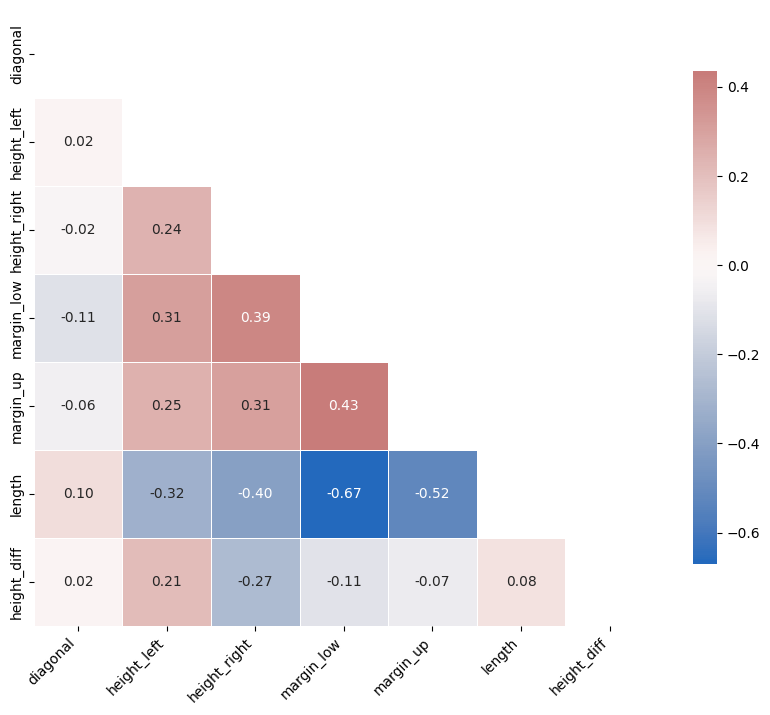

In [54]:
# on veut éviter la redondance, descendre sous 0,7 dans l'idéal (mais regarde aussi le F-score, le score de Wilks' lambda...)

corr = df[cols].corr()

# masque pour cacher la partie supérieure (le miroir)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap='vlag',
            center=0,
            linewidths=.5, 
            cbar_kws={"shrink": .8},
            annot_kws={"size": 10})

plt.xticks(rotation=45, ha='right')
plt.show()

In [56]:
# VIF détecte la multicolinéarité
# Plus proche de 1 mieux c'est. Si au dessus de 5, critique. Avoir tout près de 1 montre que chaque variable apporte une information différente.

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[cols]

X = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_df.sort_values(by="VIF", ascending=False))

        feature            VIF
0         const  593818.744723
6        length       2.142265
4    margin_low       1.943599
5     margin_up       1.419587
3  height_right       1.379994
2   height_left       1.278198
7   height_diff       1.194681
1      diagonal       1.017936


In [57]:
# Test Manova après ajout features

manova = MANOVA.from_formula(' + '.join(cols) + ' ~ is_genuine', data=df)
print(manova.mv_test())

                        Multivariate linear model
                                                                         
-------------------------------------------------------------------------
       Intercept           Value    Num DF   Den DF     F Value    Pr > F
-------------------------------------------------------------------------
          Wilks' lambda      0.0000 7.0000 1492.0000 42500514.6917 0.0000
         Pillai's trace      1.0000 7.0000 1492.0000 42500514.6917 0.0000
 Hotelling-Lawley trace 199399.1976 7.0000 1492.0000 42500514.6917 0.0000
    Roy's greatest root 199399.1976 7.0000 1492.0000 42500514.6917 0.0000
-------------------------------------------------------------------------
                                                                         
--------------------------------------------------------------------------
            is_genuine        Value   Num DF    Den DF    F Value   Pr > F
------------------------------------------------------------

In [58]:
# ANOVA / F-test
# Plus F-score est grand = varible discriminante

X = df[cols]
y = df['is_genuine']

F, p_vals = f_classif(X, y)
for col, f in zip(cols, F):
    print(f"{col}: F = {f:.1f}")

# lenght, margin low et margin up sont les variables les plus importantes

diagonal: F = 26.9
height_left: F = 252.6
height_right: F = 461.0
margin_low: F = 2380.7
margin_up: F = 870.6
length: F = 3876.7
height_diff: F = 22.1


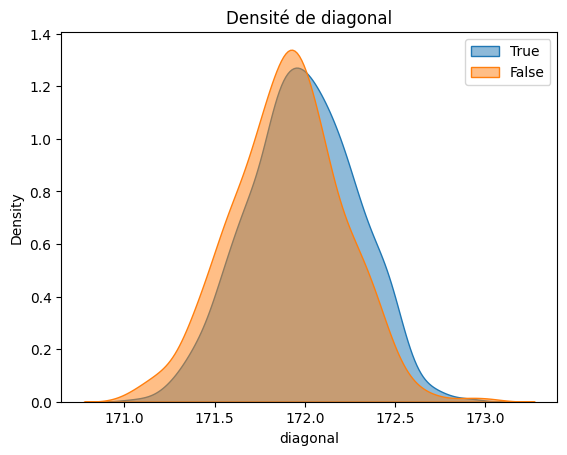

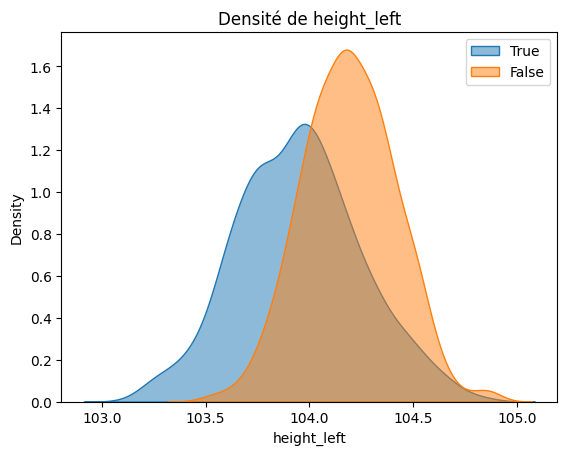

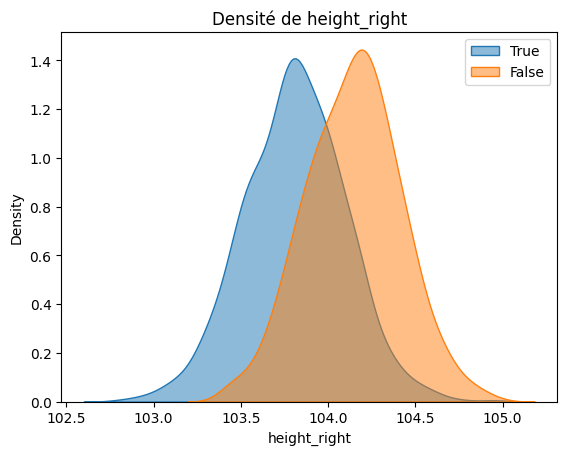

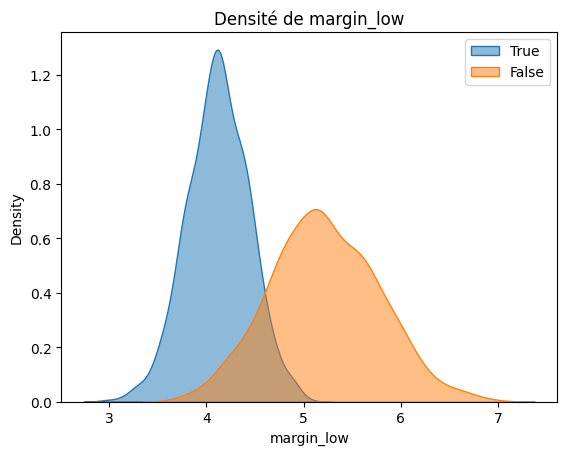

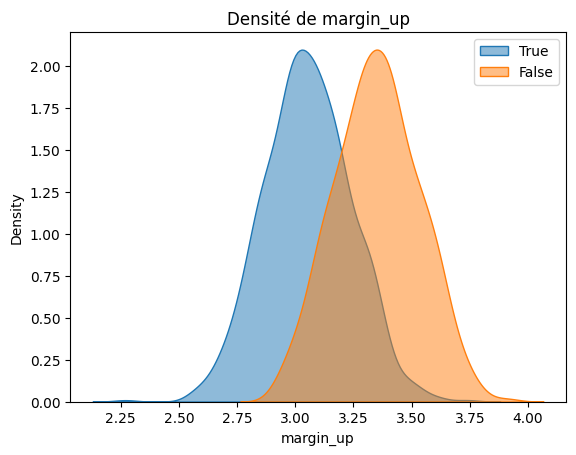

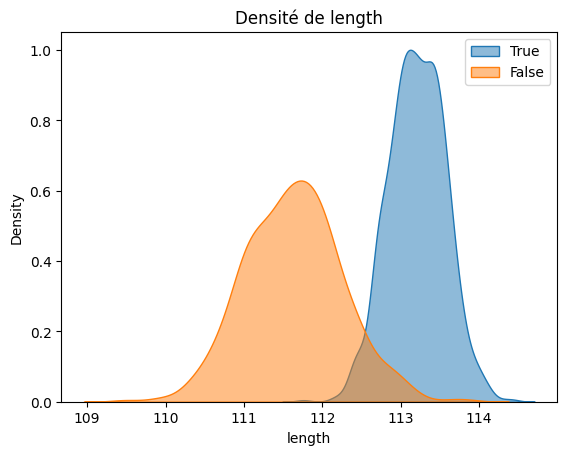

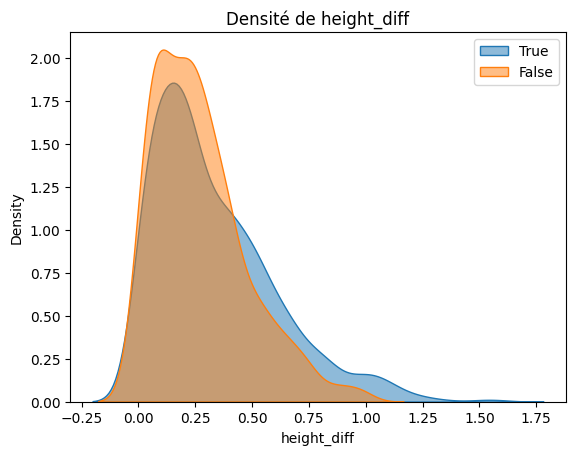

In [59]:
# Plot de densité (KDE plot)
# Regarder la densité de chaque variable permet de savoir quelles sont les variables discriminantes
# Un pic signifie que beaucoup de billets ont une certaine valeur pour telle variable. Si les courbes se chevauchent beaucoup, la variable n'est pas discriminante

for col in cols:
    sns.kdeplot(df[mask_true][col], label='True', fill=True, alpha=0.5)
    sns.kdeplot(df[mask_false][col], label='False', fill=True, alpha=0.5)
    plt.title(f"Densité de {col}")
    plt.legend()
    plt.show()


In [60]:
#cols.remove('diagonal')

In [61]:
# sns.pairplot(
#        df,
#        vars=cols,
#        hue='is_genuine',
#        diag_kind='kde',
#        palette={True: '#4A90E2', False: 'orange'},
#        plot_kws={'alpha': 0.5},
#        diag_kws={'fill': True, 'alpha': 0.5}
#  )

Préparation

In [62]:
X = df[cols]

y = df["is_genuine"]

In [63]:
# Séparation données d'entraînement et données de test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(y_train.value_counts())
print(y_test.value_counts())

is_genuine
True     800
False    400
Name: count, dtype: int64
is_genuine
True     200
False    100
Name: count, dtype: int64


In [64]:
# Standardidation pour KNN et Régression logistiques qui sont sensibles aux différences d'échelle

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
# Actuellement on a 1000 vrais contre 500 faux, les classes false risquent d'être moins apprises
# Solution 1 : Undersampling, supprimer des vrais, mais alors on perd de l'info
# Solution 2 : Oversampling, augmenter les faux, mais alors risque de sur-entraînement sur les mêmes données
# Solution 3 : pondérer les classes au moment de paramétrer le modèle avec class_weight

In [66]:
# Option : SMOTE qui permet de générer davantage d'exemples de la classe minoritaire (les faux billets)

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42) 

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Avant SMOTE :", y_train.value_counts())
print("Après SMOTE :", np.bincount(y_train_resampled))

Avant SMOTE : is_genuine
True     800
False    400
Name: count, dtype: int64
Après SMOTE : [800 800]


Modèle 1 : KMeans

c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


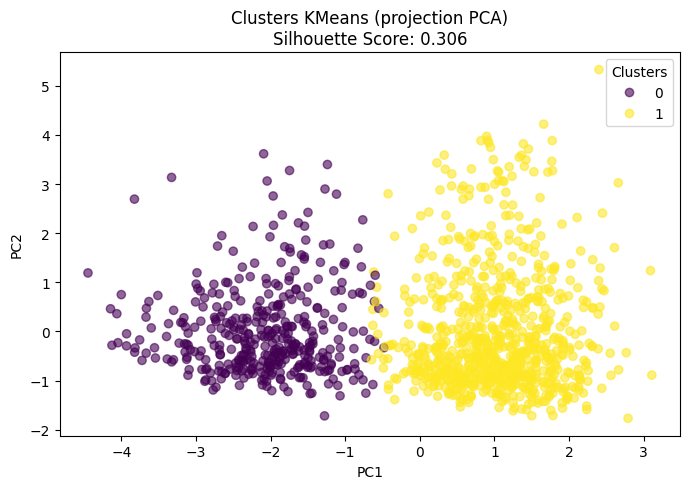

In [67]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# 1. Calcul des clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_train_scaled)

# 2. Calcul du score de Silhouette
score = silhouette_score(X_train_scaled, labels)

# 3. Visualisation
plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)

plt.legend(*scatter.legend_elements(), title="Clusters")

plt.title(f'Clusters KMeans (projection PCA)\nSilhouette Score: {score:.3f}')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


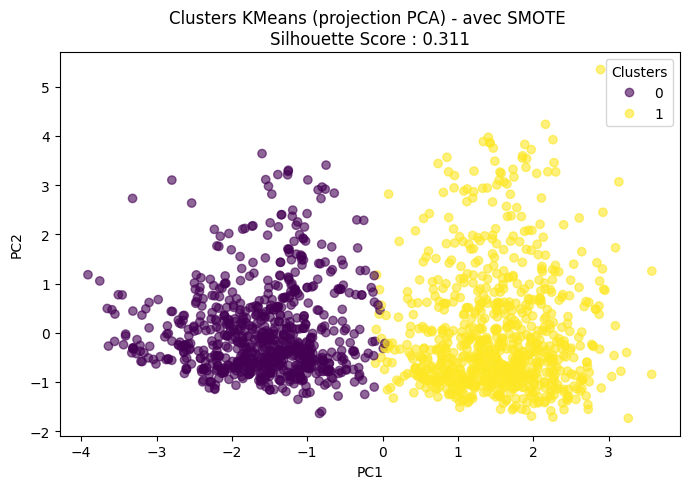

In [68]:
# avec SMOTE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

# 1. Calcul des clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_train_resampled)

# 2. Calcul du score de Silhouette
score = silhouette_score(X_train_resampled, labels)

# 3. Visualisation
plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)

plt.legend(*scatter.legend_elements(), title="Clusters")

plt.title(f'Clusters KMeans (projection PCA) - avec SMOTE \nSilhouette Score : {score:.3f}')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

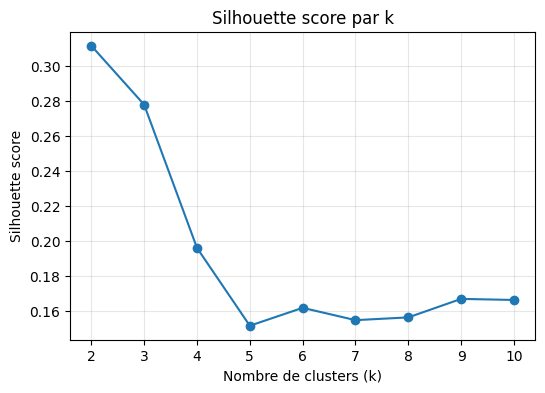

In [69]:
K = range(2, 11)
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_resampled)
    score = silhouette_score(X_train_resampled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette score par k')
plt.grid(alpha=0.3)
plt.show()

In [70]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)

kmeans.fit(X_train_scaled)

train_clusters = kmeans.predict(X_train_resampled)

c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [71]:
cluster_to_label = (
    pd.DataFrame({
        'cluster': train_clusters,
        'label': y_train_resampled
    })
    .groupby('cluster')['label']
    .agg(lambda x: x.value_counts().idxmax())
)

cluster_to_label

cluster
0    False
1     True
Name: label, dtype: bool

In [72]:
test_clusters = kmeans.predict(X_test_scaled)

In [73]:
y_pred = pd.Series(test_clusters).map(cluster_to_label)

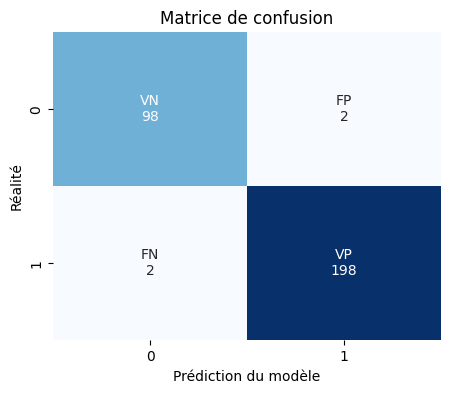

In [74]:
# confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=[0,1])

labels_matrix = np.array([['VN', 'FP'],
                          ['FN', 'VP']])
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i,j] = f"{labels_matrix[i,j]}\n{cm[i,j]}"

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.ylabel('Réalité', fontsize=10)
plt.xlabel('Prédiction du modèle', fontsize=10)
plt.show()

In [75]:
y_pred = kmeans.predict(X_test_scaled)
print("Accuracy Kmeans :", accuracy_score(y_test, y_pred))

Accuracy Kmeans : 0.9866666666666667


Modèle 2 : Régression logistique

In [76]:
# Recherche du meilleur modèle de régression logistique

logreg = LogisticRegression(max_iter=1000, random_state=42)

param_grid = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 20]
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': [0.01, 0.1, 1, 10, 20],
        'l1_ratio': [0, 0.5, 1], # Nécessaire pour elasticnet
    },
    {
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'penalty': ['l2', None],
        'C': [0.01, 0.1, 1, 10, 20]
    }
]

grid = GridSearchCV(
    logreg,
    param_grid,
    scoring='roc_auc', # Scorings possibles : 'recall', 'accuracy', 'precision', 'roc_auc'...
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)
#grid.fit(X_train_resampled, y_train_resampled)

# Meilleurs paramètres et score
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score :", grid.best_score_)

Meilleurs paramètres : {'C': 0.1, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'saga'}
Meilleur score : 0.9987187500000001


c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


In [77]:
logreg = LogisticRegression(
    penalty='l2',
    l1_ratio=0,
    C=0.1,
    solver='saga'
)

In [78]:
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)
print("Accuracy LogReg :", accuracy_score(y_test, y_pred))

y_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # probabilité pour la classe True

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC LogReg :", roc_auc)

# log loss indique la qualité des probabilités (la confiance du modèle), plus elle est basse mieux c'est

Accuracy LogReg : 0.9933333333333333
ROC-AUC LogReg : 0.9995999999999999


c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


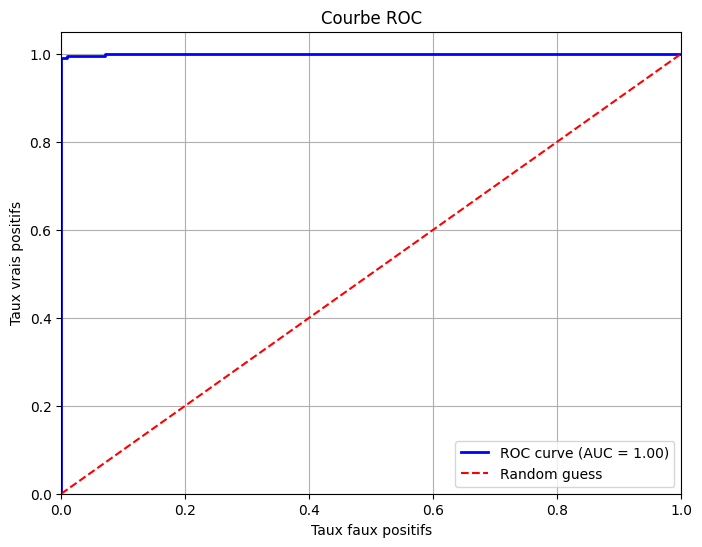

In [79]:
# Calcul des points de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Affichage de la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

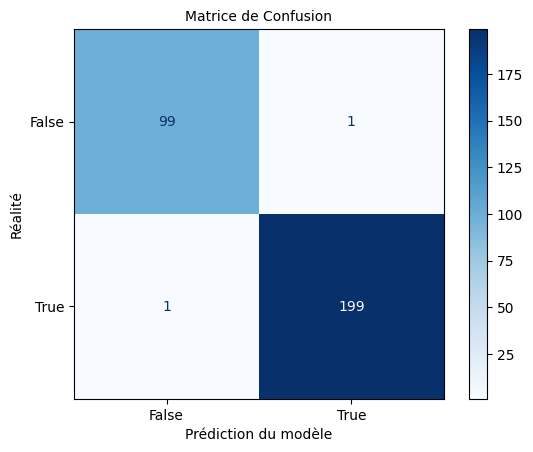

In [80]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion', fontsize=10)
plt.ylabel('Réalité', fontsize=10)
plt.xlabel('Prédiction du modèle', fontsize=10)
plt.show()

# vrai négatif (faux billet correct) ; faux positif (faux billet faussement dit vrai)
# faux négatif  ; vrai positif

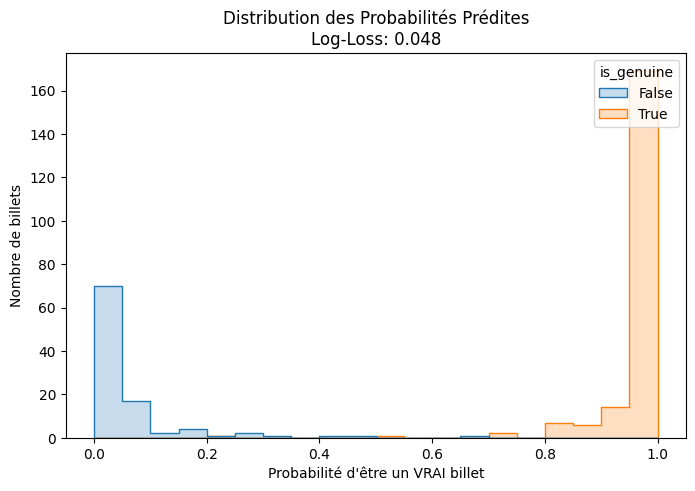

In [81]:
loss = log_loss(y_test, y_proba)

plt.figure(figsize=(8, 5))
sns.histplot(x=y_proba, hue=y_test, element="step", bins=20)
plt.title(f'Distribution des Probabilités Prédites\nLog-Loss: {loss:.3f}')
plt.xlabel('Probabilité d\'être un VRAI billet')
plt.ylabel('Nombre de billets')
plt.show()

In [82]:
scores = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Précision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_proba),
    'Log-Loss': log_loss(y_test, y_proba)
}
df_perf = pd.DataFrame(list(scores.items()), columns=['Métrique', 'Valeur'])

print("Résultats réels du modèle :")
display(df_perf)

# roc auc : qualité séparation des vrais et faux billets
# log loss : quand le modèle dit qu'un billet est vrai, la probabilité est très forte que ce soit vrai
# précision : le risque de faux positif est très bas
# recall : le risque de laisser passer un faux billet est très bas aussi
# F1-score : élevé si précision et recall sont tous les deux élevés

Résultats réels du modèle :


,Métrique,Valeur
0,Accuracy,0.993333
1,Précision,0.995000
2,Recall,0.995000
3,F1-Score,0.995000
4,ROC-AUC,0.999600
5,Log-Loss,0.048276


C:\Users\Morgi\AppData\Local\Temp\ipykernel_13388\2422176642.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='vlag')


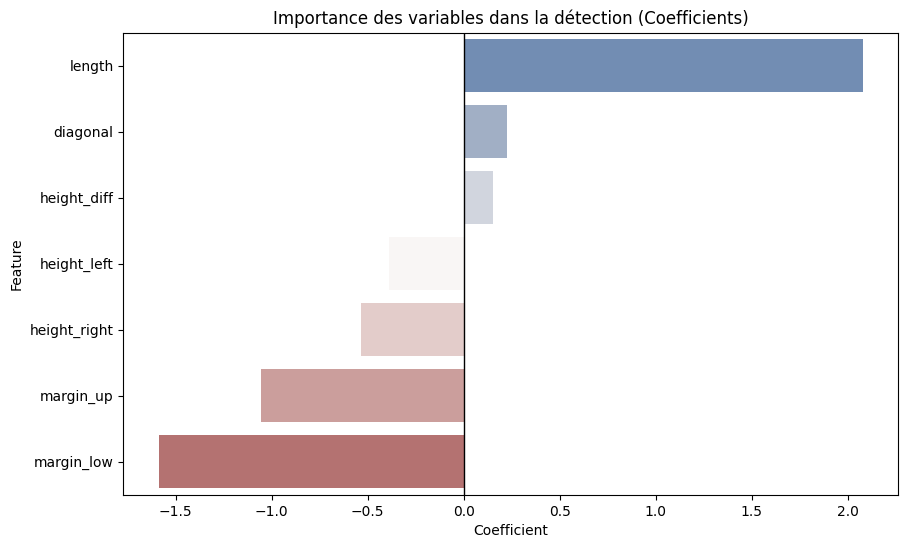

In [83]:
# Visualisation des coefficients
coef_df = pd.DataFrame({'Feature': cols, 'Coefficient': logreg.coef_[0]})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='vlag')
plt.title("Importance des variables dans la détection (Coefficients)")
plt.axvline(0, color='black', lw=1)
plt.show()

In [84]:
def verif_errors(model, X_test, y_test):

    # Prédictions et probabilités
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]  # probabilité pour la classe 1

    y_true = y_test.reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    # Masks
    fn_mask = (y_true == 1) & (y_pred == 0)
    fp_mask = (y_true == 0) & (y_pred == 1)
    correct_true_mask = (y_true == 1) & (y_pred == 1)
    correct_false_mask = (y_true == 0) & (y_pred == 0)

    # PCA pour réduire en 2D
    pca = PCA(n_components=2)
    X_test_2d = pca.fit_transform(X_test)

    df_plot = pd.DataFrame(X_test_2d, columns=['PC1','PC2'])
    df_plot['proba_true'] = y_proba
    df_plot['type'] = 'Correct'
    df_plot.loc[fn_mask, 'type'] = 'False Negative'
    df_plot.loc[fp_mask, 'type'] = 'False Positive'
    df_plot.loc[correct_true_mask, 'type'] = 'Correct True'
    df_plot.loc[correct_false_mask, 'type'] = 'Correct False'

    # Palette et tailles
    palette = {
        'False Negative':'red',
        'False Positive':'blue',
        'Correct True':'green',
        'Correct False':'orange'
    }
    sizes = df_plot['proba_true']  # plus proche de 0.5 = plus petit point

    plt.figure(figsize=(13,7))
    sns.scatterplot(data=df_plot, x='PC1', y='PC2',
                    hue='type', style='type',
                    palette=palette,
                    size=sizes, sizes=(20,200),
                    alpha=0.8)

    plt.title("Visualisation des erreurs et confiance du modèle")

    # Déplacer la légende à droite
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()


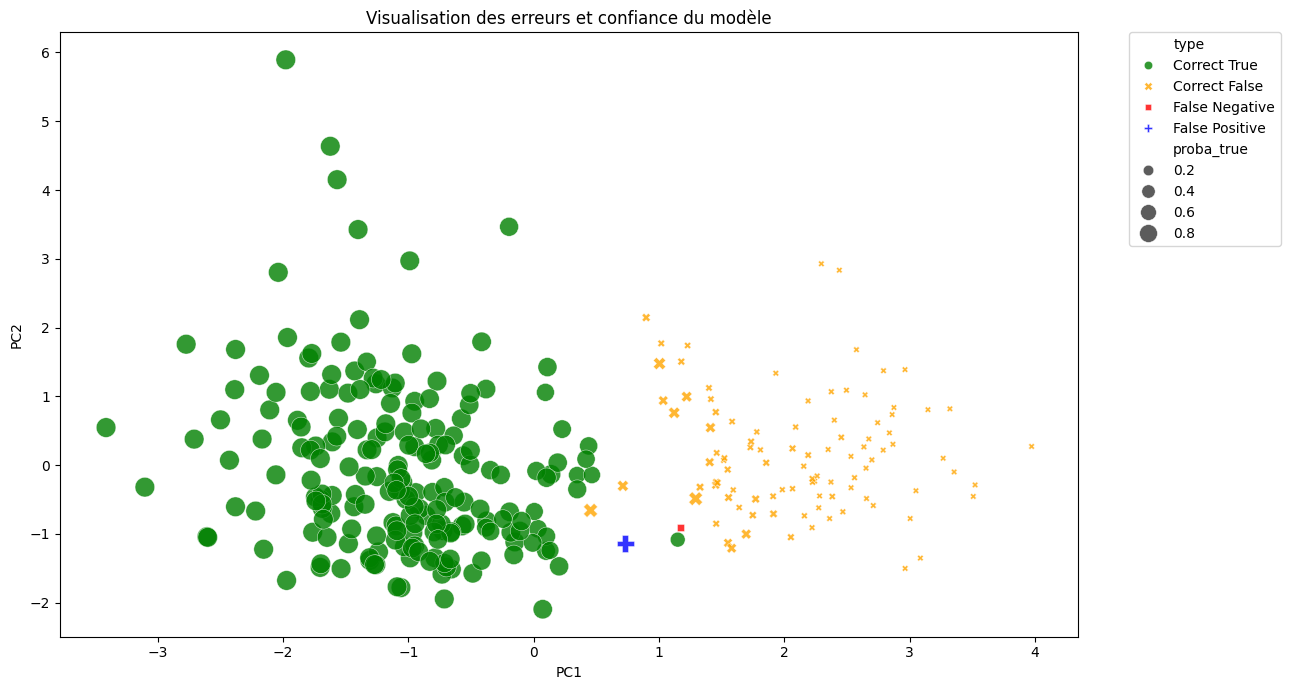

In [85]:
verif_errors(logreg, X_test_scaled, y_test)

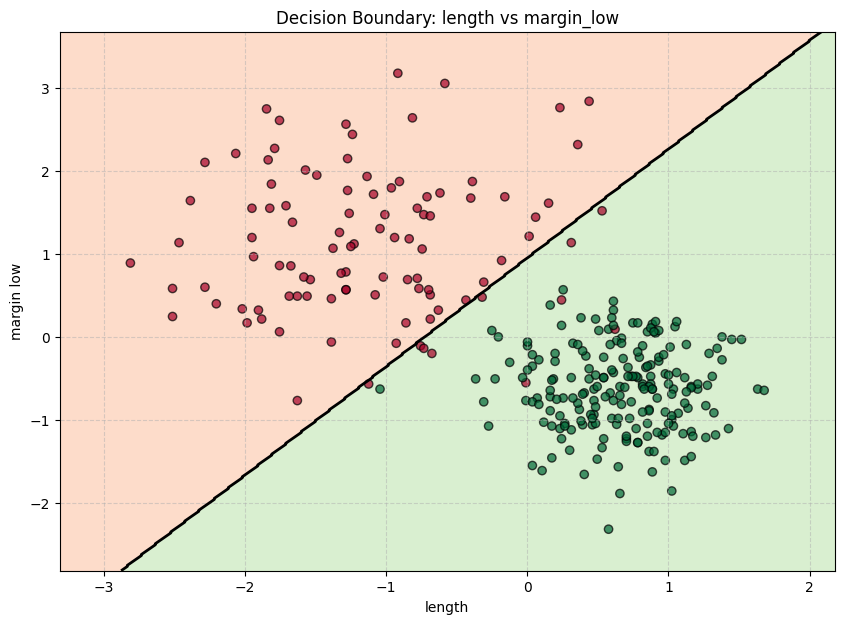

In [86]:
# variables les plus importantes
var_x_name = 'length'
var_y_name = 'margin_low'


idx_x = list(X_test.columns).index(var_x_name)
idx_y = list(X_test.columns).index(var_y_name)

x_min, x_max = X_test_scaled[:, idx_x].min() - 0.5, X_test_scaled[:, idx_x].max() + 0.5
y_min, y_max = X_test_scaled[:, idx_y].min() - 0.5, X_test_scaled[:, idx_y].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

grid_data = np.zeros((xx.ravel().shape[0], X_test_scaled.shape[1]))
grid_data[:, idx_x] = xx.ravel()
grid_data[:, idx_y] = yy.ravel()

Z = logreg.predict(grid_data)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7))

plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')

plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

plt.scatter(X_test_scaled[:, idx_x], X_test_scaled[:, idx_y], c=y_test, 
            edgecolors='k', cmap='RdYlGn', alpha=0.7)

plt.xlabel('length')
plt.ylabel('margin low')
plt.title('Logistic Regression Decision Boundary: length vs margin_low')
plt.title(f'Decision Boundary: {var_x_name} vs {var_y_name}')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Modèle 3 : KNN

In [87]:
k_values = range(1, 100)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
    #scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    cv_scores.append(scores.mean())

# Meilleur k
best_k = k_values[np.argmax(cv_scores)]
print(f"Meilleur k selon cross-validation : {best_k}, ROC-AUC = {max(cv_scores):.5f}")

Meilleur k selon cross-validation : 29, ROC-AUC = 0.99943


In [88]:
knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance') 
#knn.fit(X_train_scaled, y_train)
knn.fit(X_train_resampled, y_train_resampled)

y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)[:, 1]

print("Accuracy KNN :", accuracy_score(y_test, y_pred))
print("ROC-AUC KNN :", roc_auc_score(y_test, y_proba))

Accuracy KNN : 0.9866666666666667
ROC-AUC KNN : 0.9997000000000001


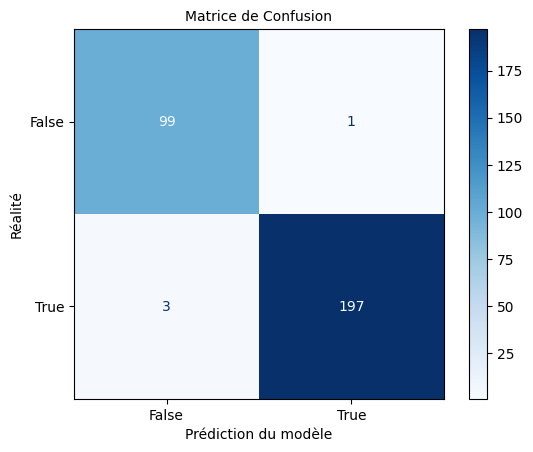

In [89]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion', fontsize=10)
plt.ylabel('Réalité', fontsize=10)
plt.xlabel('Prédiction du modèle', fontsize=10)
plt.show()

# vrai négatif (faux billet correct) ; faux positif (faux billet faussement dit vrai)
# faux négatif  ; vrai positif

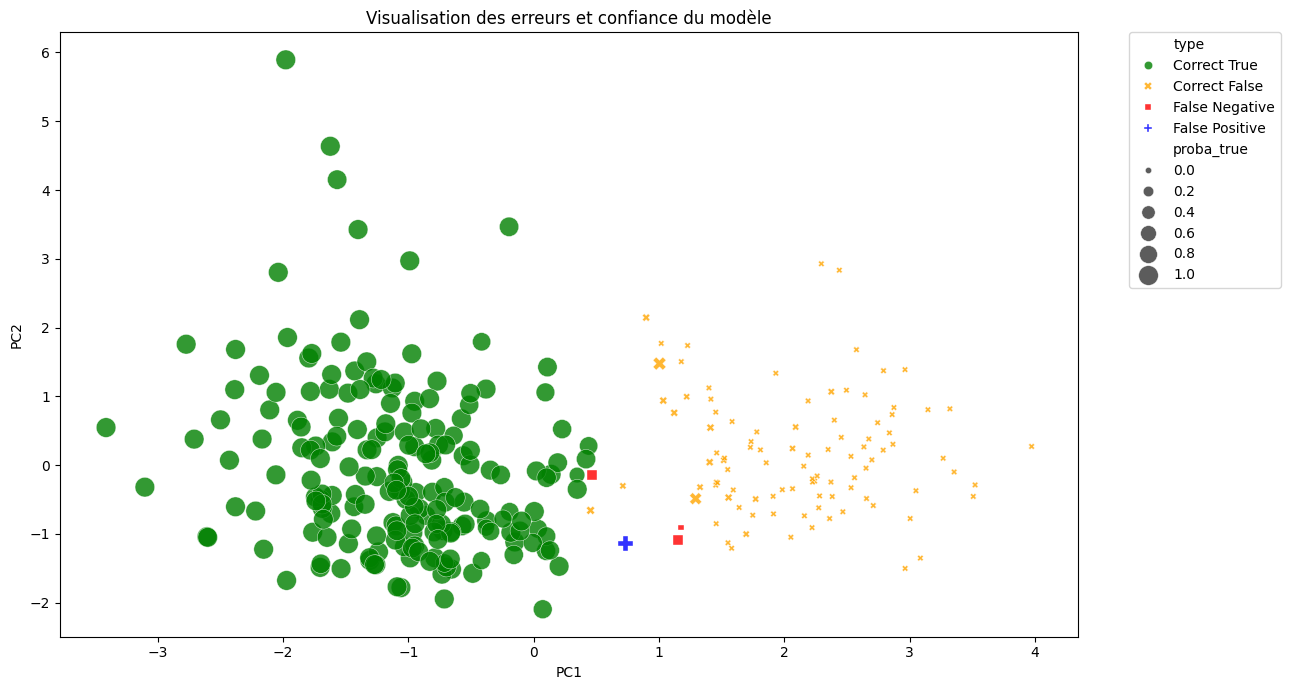

In [90]:
verif_errors(knn, X_test_scaled, y_test)

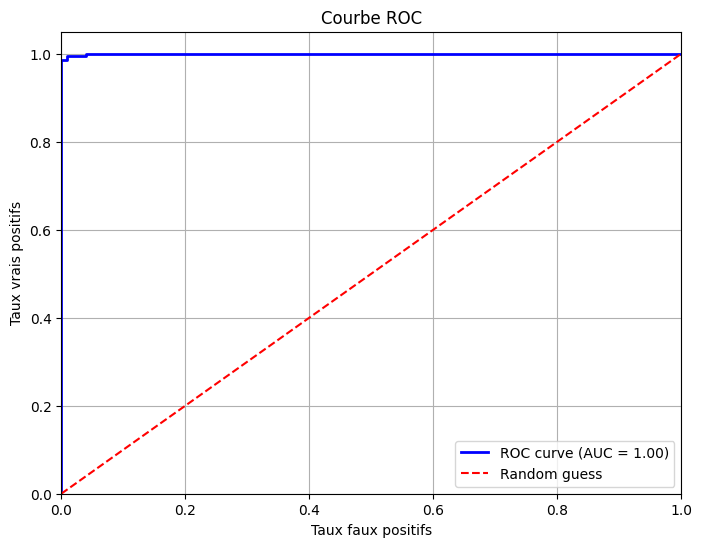

In [91]:
# Calcul des points de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Affichage de la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [92]:
scores = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Précision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_proba),
    'Log-Loss': log_loss(y_test, y_proba)
}
df_perf = pd.DataFrame(list(scores.items()), columns=['Métrique', 'Valeur'])

print("Résultats réels du modèle :")
display(df_perf)

Résultats réels du modèle :


,Métrique,Valeur
0,Accuracy,0.986667
1,Précision,0.994949
2,Recall,0.985000
3,F1-Score,0.989950
4,ROC-AUC,0.999700
5,Log-Loss,0.032939


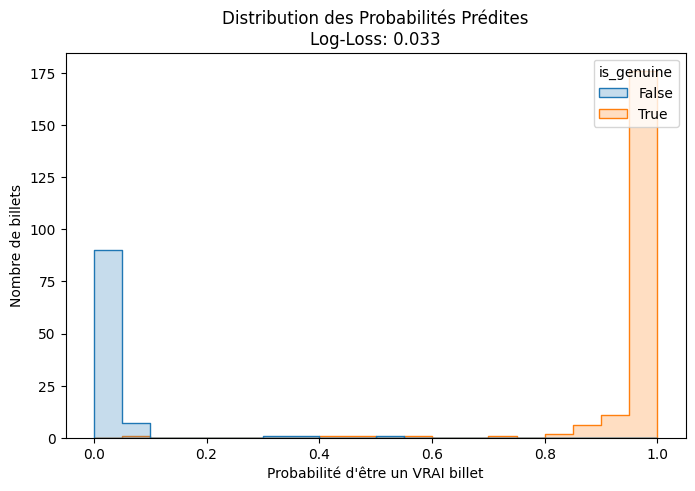

In [93]:
loss = log_loss(y_test, y_proba)

plt.figure(figsize=(8, 5))
sns.histplot(x=y_proba, hue=y_test, element="step", bins=20)
plt.title(f'Distribution des Probabilités Prédites\nLog-Loss: {loss:.3f}')
plt.xlabel('Probabilité d\'être un VRAI billet')
plt.ylabel('Nombre de billets')
plt.show()

Modèle 3 : Random Forest

In [94]:
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 0.5]
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

grid_rf = GridSearchCV(
    rf,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train_resampled, y_train_resampled)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}
0.9998320312499999


In [95]:
rf = RandomForestClassifier(
    n_estimators=500,  # nombre d’arbres
    max_features= 'sqrt',
    random_state=42,
    min_samples_leaf= 1,
    max_depth=10,    # pas de limite de profondeur
    n_jobs=-1          # utiliser tous les cœurs CPU
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy Random Forest :", accuracy_score(y_test, y_pred))
print("ROC-AUC Random Forest :", roc_auc_score(y_test, y_proba))

Accuracy Random Forest : 0.99
ROC-AUC Random Forest : 0.9992


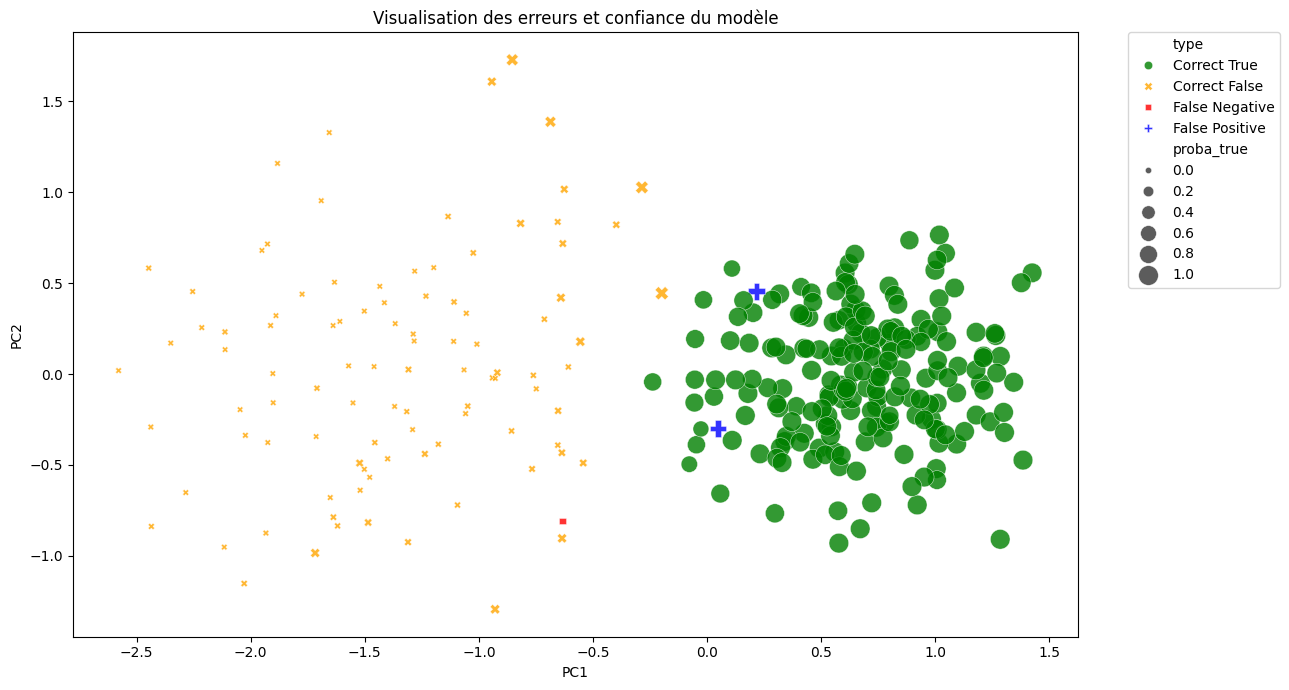

In [96]:
verif_errors(rf, X_test, y_test)

In [97]:
scores = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Précision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_proba),
    'Log-Loss': log_loss(y_test, y_proba)
}
df_perf = pd.DataFrame(list(scores.items()), columns=['Métrique', 'Valeur'])

print("Résultats réels du modèle :")
display(df_perf)

Résultats réels du modèle :


,Métrique,Valeur
0,Accuracy,0.990000
1,Précision,0.990050
2,Recall,0.995000
3,F1-Score,0.992519
4,ROC-AUC,0.999200
5,Log-Loss,0.044569


c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


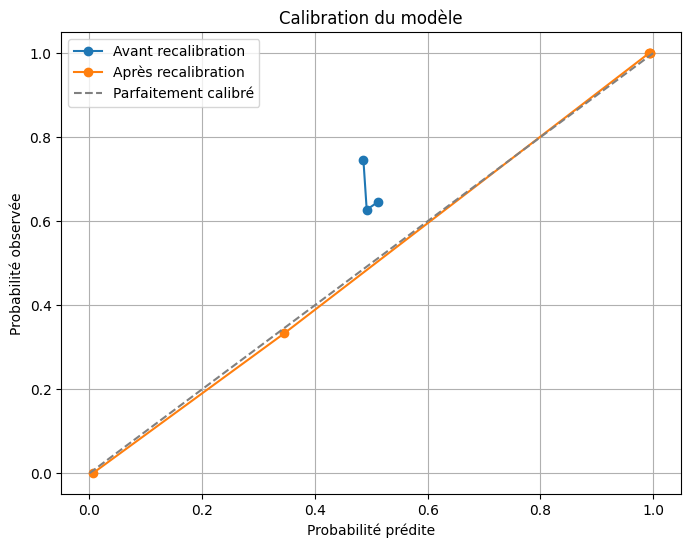

In [98]:
calibrated_rf = CalibratedClassifierCV(
    estimator=rf, 
    method='sigmoid',  #'isotonic' ou 'sigmoid'
    cv=5  # cross-validation interne pour la recalibration
)

calibrated_rf.fit(X_train_resampled, y_train_resampled)

# Probabilités avant recalibration
y_proba_before = rf.predict_proba(X_test_scaled)[:, 1]

# Probabilités après recalibration
y_proba_after = calibrated_rf.predict_proba(X_test_scaled)[:, 1]

# Calcul de la calibration curve
prob_true_before, prob_pred_before = calibration_curve(y_test, y_proba_before, n_bins=5, strategy='quantile')
prob_true_after, prob_pred_after = calibration_curve(y_test, y_proba_after, n_bins=5, strategy='quantile')

plt.figure(figsize=(8,6))
plt.plot(prob_pred_before, prob_true_before, marker='o', label='Avant recalibration')
plt.plot(prob_pred_after, prob_true_after, marker='o', label='Après recalibration')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Parfaitement calibré')
plt.xlabel("Probabilité prédite")
plt.ylabel("Probabilité observée")
plt.title("Calibration du modèle")
plt.legend()
plt.grid(True)
plt.show()


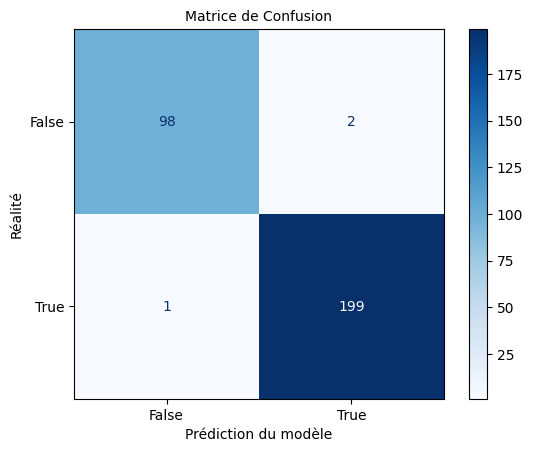

In [99]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion', fontsize=10)
plt.ylabel('Réalité', fontsize=10)
plt.xlabel('Prédiction du modèle', fontsize=10)
plt.show()

# vrai négatif (faux billet correct) ; faux positif (faux billet faussement dit vrai)
# faux négatif  ; vrai positif

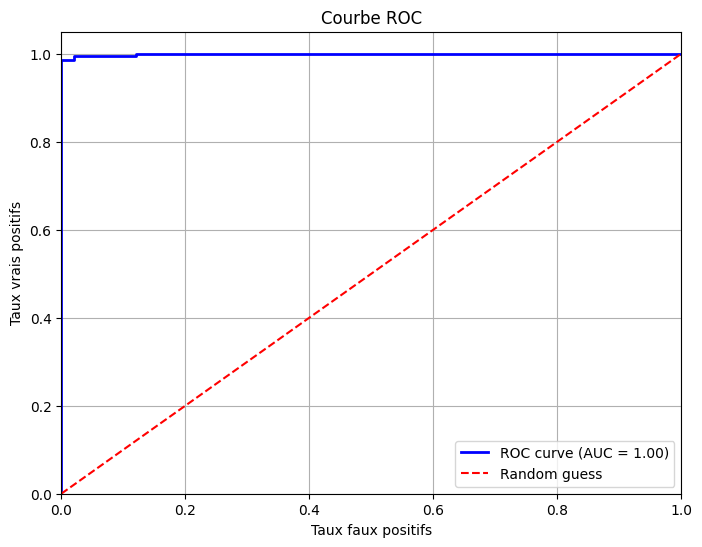

In [100]:
# Calcul des points de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Affichage de la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

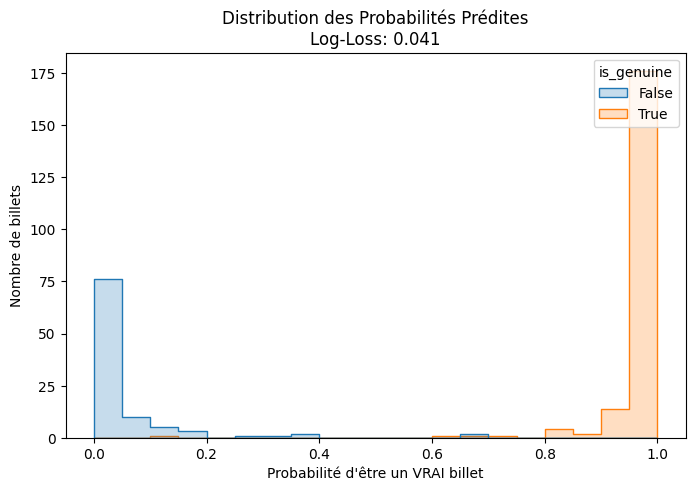

In [101]:
loss = log_loss(y_test, y_proba_after)

plt.figure(figsize=(8, 5))
sns.histplot(x=y_proba, hue=y_test, element="step", bins=20)
plt.title(f'Distribution des Probabilités Prédites\nLog-Loss: {loss:.3f}')
plt.xlabel('Probabilité d\'être un VRAI billet')
plt.ylabel('Nombre de billets')
plt.show()

Autres modèles

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

lda.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
lda_probs = lda.predict_proba(X_test)

print("Accuracy LDA :", accuracy_score(y_test, y_pred))
print("ROC-AUC LDA :", roc_auc_score(y_test, y_proba))
print(f"Log Loss LDA : {log_loss(y_test, lda_probs):.4f}")

Accuracy Random Forest : 0.99
ROC-AUC Random Forest : 0.9992
Log Loss LDA : 12.0146


c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


In [ ]:
svm_model = SVC(kernel='rbf', C=0.1, gamma=0.1, probability=True, random_state=42)

svm_model.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
svm_probs = svm_model.predict_proba(X_test)

print("Accuracy SVM :", accuracy_score(y_test, y_pred))
print("ROC-AUC SVM :", roc_auc_score(y_test, y_proba))
print(f"Log Loss SVM : {log_loss(y_test, svm_probs):.4f}")

Accuracy Random Forest : 0.99
ROC-AUC Random Forest : 0.9992
Log Loss SVM : 0.6805


c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
X_true_train = X_train_scaled[y_train == 1]

# 2. Configuration du One-Class SVM
# nu : définit le pourcentage d'anomalies attendues dans les données saines (ex: 1%)
# gamma : définit la souplesse de la bulle (plus il est petit, plus la bulle est large)

oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.009)

oc_svm.fit(X_true_train)

# Résultat : 1 pour "Normal", -1 pour "Anomalie/Hors-bulle"
y_outliers = oc_svm.predict(X_test_scaled)

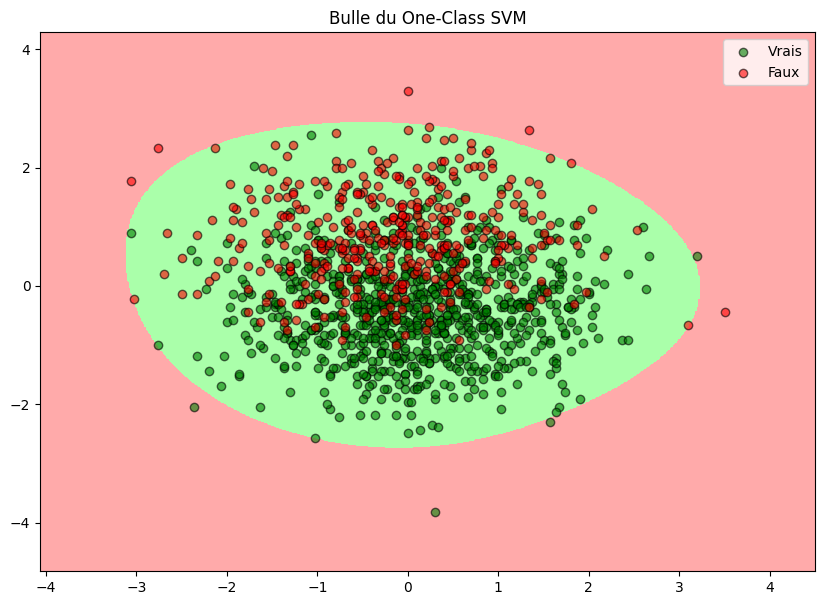

In [106]:
def plot_boundary(model, X, y, features_idx=[0, 1], title="Frontière de décision"):
    # On ne garde que deux variables pour le graph (ex: Longueur vs Marge_bas)
    X_visu = X[:, features_idx]
    model.fit(X_visu) # On réentraîne rapidement sur 2D pour le graph
    
    # Création d'une grille pour dessiner la frontière
    x_min, x_max = X_visu[:, 0].min() - 1, X_visu[:, 0].max() + 1
    y_min, y_max = X_visu[:, 1].min() - 1, X_visu[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    # Prédiction sur toute la grille
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 7))
    # Dessin de la frontière (zone colorée)
    plt.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], colors=['#FFAAAA', '#AAFFAA'])
    
    # Affichage des points (Vrais en vert, Faux en rouge)
    plt.scatter(X_visu[y==1, 0], X_visu[y==1, 1], c='green', edgecolors='k', label='Vrais', alpha=0.6)
    plt.scatter(X_visu[y==0, 0], X_visu[y==0, 1], c='red', edgecolors='k', label='Faux', alpha=0.6)
    
    plt.title(title)
    plt.legend()
    plt.show()

# Exemple d'utilisation pour le One-Class SVM
# On choisit les colonnes 0 et 4 (à adapter selon ton dataset)
plot_boundary(oc_svm, X_train_scaled, y_train, features_idx=[0, 4], title="Bulle du One-Class SVM")

Modèle final

In [107]:
X = df[cols]
y = df['is_genuine']

X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,height_diff
0,171.81,104.86,104.95,4.52,2.89,112.83,0.09
1,171.46,103.36,103.66,3.77,2.99,113.09,0.30
2,172.69,104.48,103.50,4.40,2.94,113.16,0.98
3,171.36,103.91,103.94,3.62,3.01,113.51,0.03
4,171.73,104.28,103.46,4.04,3.48,112.54,0.82


In [108]:
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        penalty='l2',
        l1_ratio=0,
        C=0.1,
        solver='saga'
    ))
])

In [109]:
logreg_pipeline.fit(X, y)

c:\Users\Morgi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1


In [110]:
oc_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', OneClassSVM(kernel='rbf', gamma=0.1, nu=0.009))
])

In [111]:
X_true = X[y == 1]

oc_svm_pipeline.fit(X_true)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,kernel,'rbf'
,degree,3
,gamma,0.1
,coef0,0.0


In [112]:
joblib.dump(logreg_pipeline, "logreg_pipeline.pkl")

['logreg_pipeline.pkl']

In [113]:
joblib.dump(oc_svm_pipeline, "oc_svm_pipeline.pkl")

['oc_svm_pipeline.pkl']